# TOA radiation evaluation for nextGEMS cycle 3

contributed by Sebastian Milinski (sebastian.milinski@ecmwf.int), based on [STARTHERE_IFS.ipynb](https://github.com/nextGEMS/nextGEMS_Cycle3/blob/main/IFS/STARTHERE_IFS.ipynb) by Thomas Rackow (thomas.rackow@ecmwf.int)

- Includes basic metrics for top-of-atmosphere (TOA) radiation and surface temperature.
- global mean and regional
- reference datasets: CERES (radiation), ERA5 (temperature)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
#import gribscan
#import intake
# Impoddrt Cdo-py
#import cdo
#cdo = cdo.Cdo(tempdir='/work/bb1153/a270046/tmp/cdo-py/') #change the tempdir to your scratch

#import cartopy.crs as ccrs
import calendar # convert month numbers into month name strings with calendar.month_name[1] => 'January'
# all-caps month abbr: calendar.month_abbr[1].upper() => 'JAN'
import os

plotdir = './plots/radiation/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)


## load model output

In [2]:
import pickle

In [3]:
pickle.HIGHEST_PROTOCOL

5

In [4]:
with open('../data/data_FigTOA.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    models,TOA_ceres_diff_samples_gm,TOA_ceres_clim_gm = pickle.load(f)

In [5]:
models = [models[0],
          models[1],
#          TOA_ifs_28km_gm.squeeze(),
#          TOA_icon_5km_gm.squeeze(),
         ]

## plot

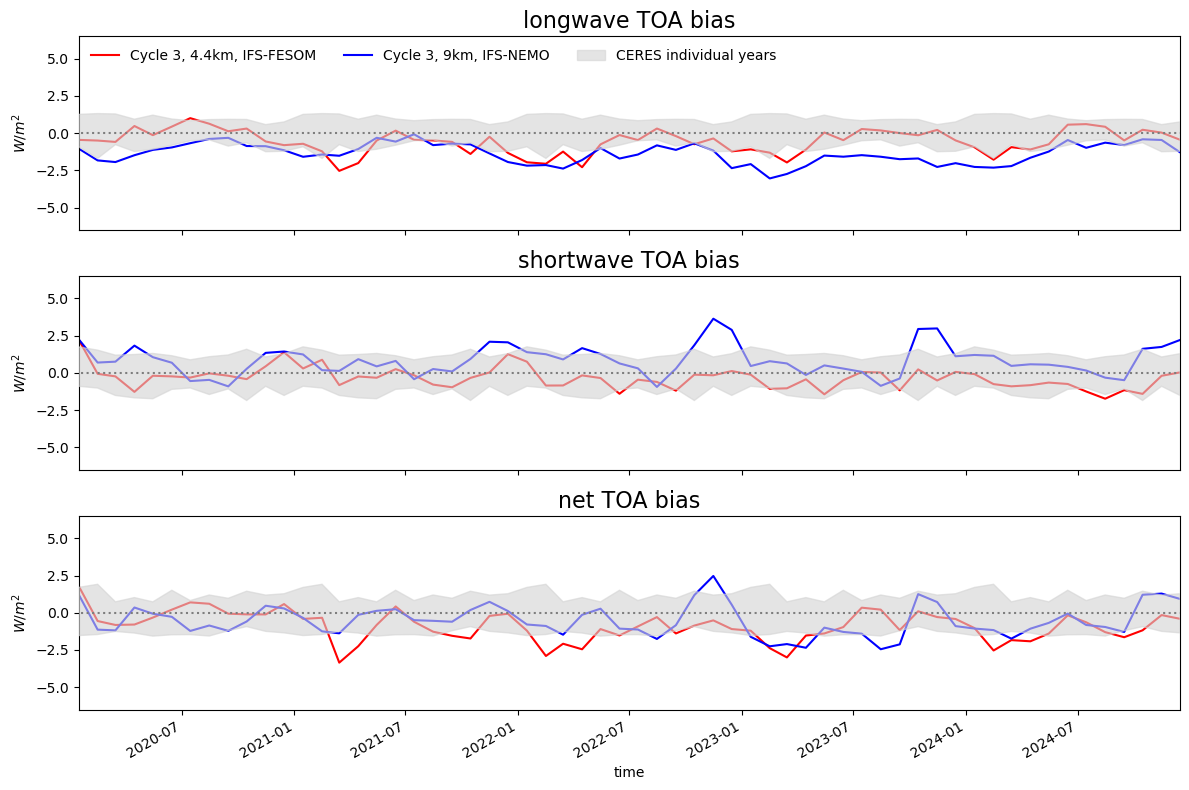

In [6]:
fig, axes = plt.subplots(3, 1,figsize=(12,8))
linecolors = ['red',
              'blue',
              'cyan',
              'green',
             ]
linelabels = ['Cycle 3, 4.4km, IFS-FESOM',
              'Cycle 3, 9km, IFS-NEMO',
#              'Cycle 3, 28 km km, IFS / NEMO',
#              'Cycle 3, 5 km, ICON',
             ]

# duplicate CERES IV sampels and concatenate years to plot one connected envelope for IV uncertainty
shading_data = xr.concat((TOA_ceres_diff_samples_gm, 
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[0].ttr.sel(time='2021').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[0].ttr.sel(time='2022').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[0].ttr.sel(time='2023').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[0].ttr.sel(time='2024').time),
                         ),dim='time' )
long_time=np.append(shading_data['time'],shading_data['time'][::-1])


# panel a

for i,model in enumerate(models):
    xr.concat(((model.ttr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().ttr.values),
               (model.ttr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().ttr.values),
               (model.ttr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().ttr.values),
               (model.ttr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().ttr.values),
               (model.ttr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().ttr.values)),
              dim='time').plot(ax=axes[0],color=linecolors[i],label=linelabels[i],x='time')


axes[0].fill(long_time,np.append(shading_data['ttr'].min(dim='ensemble'),shading_data['ttr'].max(dim='ensemble')[::-1]),color='lightgrey',alpha=0.6,label='CERES individual years',zorder=4)


axes[0].set_title('longwave TOA bias',fontsize=16)
axes[0].set_xticklabels([])
axes[0].set_xlabel('')
axes[0].legend(loc="upper left",frameon=False,fontsize='medium',ncol=3)

# # # panel b
for i,model in enumerate(models):
    xr.concat(((model.tsr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().tsr.values),
               (model.tsr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().tsr.values),
               (model.tsr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().tsr.values),
               (model.tsr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().tsr.values),
               (model.tsr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().tsr.values)),
              dim='time').plot(ax=axes[1],color=linecolors[i],label=linelabels[i],x='time')


axes[1].fill(long_time,np.append(shading_data['tsr'].min(dim='ensemble'),shading_data['tsr'].max(dim='ensemble')[::-1]),color='lightgrey',alpha=0.6,label='CERES individual years',zorder=4)

axes[1].set_title('shortwave TOA bias',fontsize=16)
axes[1].set_xticklabels([])
axes[1].set_xlabel('')

# # # panel c
for i,model in enumerate(models):
    xr.concat(((model.tnr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().tnr.values),
               (model.tnr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().tnr.values),
               (model.tnr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().tnr.values),
               (model.tnr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().tnr.values),
               (model.tnr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().tnr.values)),
              dim='time').plot(ax=axes[2],color=linecolors[i],label=linelabels[i],x='time')

axes[2].fill(long_time,np.append(shading_data['tnr'].min(dim='ensemble'),shading_data['tnr'].max(dim='ensemble')[::-1]),color='lightgrey',alpha=0.6,label='CERES individual years',zorder=4)
axes[2].set_title('net TOA bias',fontsize=16)

for i in range(3):
    axes[i].set_ylabel('$W/m^2$')
    axes[i].set_xlim([pd.to_datetime('2020-01-15'),pd.to_datetime('2024-12-15')])
    axes[i].plot([pd.to_datetime('2020-01-01'),pd.to_datetime('2030-12-31')],[0,0],color='black',linestyle=':')
    axes[i].set_ylim([-6.5,6.5])


#plt.suptitle('global mean TOA radiation bias rel. to CERES climatology',fontsize=18)
plt.tight_layout()    

plt.savefig(plotdir + 'TOA_bias_clim_global_mean_cycle3.png')